# Big Vision Internship Assignment: Car Segmentation Using U-Net
#

This Google Colab Notebook documents the complete process for the Big Vision Internship Assignment focused on Semantic Segmentation of Cars.The core objective of this project is to implement, train, and evaluate a robust deep learning model capable of generating pixel-accurate segmentation masks for vehicles.Key Methodological



Steps:



- Dataset Engineering: A custom segmentation dataset was generated by taking the Stanford Cars Dataset and automatically creating high-quality ground-truth masks for car instances using the state-of-the-art YOLOv8x  model.


- Model Implementation: The segmentation task is handled by a specialized U-Net architecture. To maximize performance and efficiency, the model utilizes EfficientNet B3 as a pre-trained backbone (encoder) for superior feature extraction, leveraging the benefits of transfer learning.


- Training & Evaluation: The model was trained with appropriate loss functions and data augmentation techniques. Performance was rigorously assessed using standard metrics such as Mean IoU and the Dice Coefficient, along with Pixel Accuracy, Precision, and Recall.The notebook proceeds with a step-by-step walkthrough of the data preparation, model construction, training pipeline, and a comprehensive visualization of the final segmentation results.

# Automated Data Annotation: Leveraging YOLOv8x for Segmentation Masks




###This section details the custom dataset creation phase, where the raw images from the Stanford Cars Dataset were annotated with high-quality ground-truth segmentation masks.

###To fulfill the assignment requirement of using a state-of-the-art model for labeling, the YOLOv8x-seg  model was utilized. This approach automates the creation of pixel-accurate masks, which are essential for training the U-Net architecture.



-------------------------------------------------------------------

The following cell loads the pre-trained weights of the powerful YOLOv8x variant.

In [ ]:
# Install the necessary library (YOLOv8)
#Using this because Yolo model is pre installed in this
!pip install ultralytics
import cv2
import numpy as np
import torch
from ultralytics import YOLO

# Load a pre-trained segmentation model
#We are going to use Yolov8x segmentation model, This x refers for xl and this is the best model for segmentation in yolo, although yolo provides nano,medium,large too
model = YOLO('yolov8x-seg.pt')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


####Mounting Google drive to access our dataset

In [ ]:
from google.colab import drive
# This command mounts your Google Drive to the path /content/drive
drive.mount('/content/drive')

Mounted at /content/drive


Checking Cuda availability

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda:0


In [ ]:
Checking which device

In [ ]:
!nvidia-smi

Thu Oct 30 06:20:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Step 1: Creating Car Segmentation Masks Using YOLOv8

### In this step, we generate segmentation masks for our training dataset and save them to /content/drive/MyDrive/Car/cars/cars_train/cars_train_mask_yolov8x.\

We utilize YOLOv8x-seg, a state-of-the-art instance segmentation model, to automatically create segmentation masks for each image. Since YOLO detects multiple object categories, we specifically extract masks corresponding only to the ‘car’ class (class ID = 2 in the COCO dataset).

Each output mask is a binary (1-channel) semantic mask, where:

- White (255) pixels represent car regions (foreground).

- Black (0) pixels represent the background and all non-car objects.

This process effectively converts YOLO’s instance-level predictions into semantic segmentation masks suitable for training the U-Net model in later stages.

In [ ]:

# Install necessary libraries: PyTorch for model, SMP for architecture, others for data handling
!pip install -q torch torchvision numpy opencv-python Pillow
# Note: Ultralytics is already a dependency of YOLO
from google.colab import drive
import os
import glob
import cv2
import numpy as np
import torch
from ultralytics import YOLO
from tqdm import tqdm

# --- DEVICE SETUP: ENSURE CUDA IS USED ---
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")




#Dataset path
DRIVE_PATH = '/content/drive/MyDrive/Car/cars/cars_train'
INPUT_IMAGE_DIR = os.path.join(DRIVE_PATH, 'cars_train')
OUTPUT_MASK_DIR = os.path.join(DRIVE_PATH, 'cars_train_mask_yolov8x')


# Create the output directory if it doesn't exist
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)
print(f"Input Images: {INPUT_IMAGE_DIR}")
print(f"Output Masks will be saved to: {OUTPUT_MASK_DIR}")

# SOTA Model Selection (Load a pretrained segmentation model)
# Model weights will be downloaded automatically on first run
model = YOLO('yolov8x-seg.pt')

# Class ID for 'car' in the default COCO dataset (common for YOLO pre-trained models)
CAR_CLASS_ID = 2

#  DATA PREPARATION
# 1. Get list of all image files (updated to cover common formats)
image_files = []
# Ensure all common image extensions are searched (case-insensitive for robustness)
for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
    image_files.extend(glob.glob(os.path.join(INPUT_IMAGE_DIR, ext)))

if not image_files:
    print(f"ERROR: No images found in the directory: {INPUT_IMAGE_DIR}")
else:
    print(f"Found {len(image_files)} images for auto-labeling.")


# Use tqdm for a progress bar it is good you get to know how much percentage is completed e
for image_path in tqdm(image_files, desc="Generating Masks"):

    # 1. Run the segmentation model on the image
    # The 'device' parameter explicitly tells the model to use the GPU
    results = model.predict(source=image_path, save=False, verbose=False, device=DEVICE)

    result = results[0]

    # Check if any segmentation masks were generated
    if result.masks is not None:
        # 2. Extract masks and class IDs
        # Masks are normalized to image size by default in Ultralytics
        masks_data = result.masks.data
        # Class IDs are already on the CPU, ensuring compatibility with torch.where
        class_ids = result.boxes.cls.cpu()

        # 3. Filter for ONLY 'car' instances
        car_indices = torch.where(class_ids == CAR_CLASS_ID)
        car_masks = masks_data[car_indices] # Select only the masks corresponding to cars

        # 4. Create a single binary mask for all cars (Semantic Mask)
        if len(car_masks) > 0:
            # Combine all 'car' instance masks using OR logic (torch.any)
            # Send mask tensor to CPU before conversion to numpy
            final_mask_tensor = torch.any(car_masks, dim=0).int() * 255
            final_mask_np = final_mask_tensor.cpu().numpy().astype(np.uint8)

            # 5. Save the mask (the Ground Truth Label for U-Net)
            base_filename = os.path.basename(image_path).rsplit('.', 1)[0]
            mask_filename = os.path.join(OUTPUT_MASK_DIR, f"{base_filename}.png")

            # Save the 1-channel binary mask image
            cv2.imwrite(mask_filename, final_mask_np)

print("\nAuto-labeling complete. Masks are saved to:", OUTPUT_MASK_DIR)

Using device: cuda:0
Input Images: /content/drive/MyDrive/Car/cars/cars_train/cars_train
Output Masks will be saved to: /content/drive/MyDrive/Car/cars/cars_train/cars_train_mask_yolov8x
Found 8144 images for auto-labeling.


Generating Masks: 100%|██████████| 8144/8144 [30:20<00:00,  4.47it/s]


🎉 Auto-labeling complete. Masks are saved to: /content/drive/MyDrive/Car/cars/cars_train/cars_train_mask_yolov8x


## Doing it for test masks now

In [ ]:
##USING YOLOV8 XL MODEL FOR TEST DATA

DRIVE_PATH = '/content/drive/MyDrive/Car/cars/cars_test'
INPUT_IMAGE_DIR = os.path.join(DRIVE_PATH, 'cars_test')
OUTPUT_MASK_DIR = os.path.join(DRIVE_PATH, 'cars_test_mask_yolov8x')


# Create the output directory if it doesn't exist
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)
print(f"Input Images: {INPUT_IMAGE_DIR}")
print(f"Output Masks will be saved to: {OUTPUT_MASK_DIR}")


# Model weights will be downloaded automatically on first run
model = YOLO('yolov8x-seg.pt')

# Class ID for 'car' in the default COCO dataset (common for YOLO pre-trained models)
CAR_CLASS_ID = 2



# 1. Get list of all image files (updated to cover common formats)
image_files = []
# Ensure all common image extensions are searched (case-insensitive for robustness)
for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
    image_files.extend(glob.glob(os.path.join(INPUT_IMAGE_DIR, ext)))

if not image_files:
    print(f"ERROR: No images found in the directory: {INPUT_IMAGE_DIR}")

else:
    print(f"Found {len(image_files)} images for auto-labeling.")

for image_path in tqdm(image_files, desc="Generating Masks"):

    # 1. Run the segmentation model on the image
    # The 'device' parameter explicitly tells the model to use the GPU (cuda:0)
    results = model.predict(source=image_path, save=False, verbose=False, device=DEVICE)

    # print(f"{len(results)}") # This line is often noisy, removed for cleaner output

    result = results[0] # Get the results for the current image

    # Check if any segmentation masks were generated
    if result.masks is not None:
        # 2. Extract masks and class IDs
        # Masks are normalized to image size by default in Ultralytics
        masks_data = result.masks.data
        # Class IDs are already on the CPU, ensuring compatibility with torch.where
        class_ids = result.boxes.cls.cpu()

        # 3. Filter for ONLY 'car' instances
        car_indices = torch.where(class_ids == CAR_CLASS_ID)
        car_masks = masks_data[car_indices] # Select only the masks corresponding to cars

        # 4. Create a single binary mask for all cars (Semantic Mask)
        if len(car_masks) > 0:
            # Combine all 'car' instance masks using OR logic (torch.any)
            # Send mask tensor to CPU before conversion to numpy
            final_mask_tensor = torch.any(car_masks, dim=0).int() * 255
            final_mask_np = final_mask_tensor.cpu().numpy().astype(np.uint8)

            # 5. Save the mask (the Ground Truth Label for U-Net)
            base_filename = os.path.basename(image_path).rsplit('.', 1)[0]
            mask_filename = os.path.join(OUTPUT_MASK_DIR, f"{base_filename}.png")

            # Save the 1-channel binary mask image
            cv2.imwrite(mask_filename, final_mask_np)

print("\n Auto-labeling complete. Masks are saved to:", OUTPUT_MASK_DIR)

Input Images: /content/drive/MyDrive/Car/cars/cars_test/cars_test
Output Masks will be saved to: /content/drive/MyDrive/Car/cars/cars_test/cars_test_mask_yolov8x
Found 8041 images for auto-labeling.


Generating Masks: 100%|██████████| 8041/8041 [3:13:21<00:00,  1.44s/it]


 Auto-labeling complete. Masks are saved to: /content/drive/MyDrive/Car/cars/cars_test/cars_test_mask_yolov8x



-----------------------------

#TRAINING STARTED


-------------------





#Installing and Importing Libraries for Model Training

In this step, we install and import the necessary libraries required for training the segmentation model.
We specifically use Segmentation Models PyTorch (SMP),a popular and powerful library for building image segmentation architectures like U-Net


The key advantage of SMP is that it provides access to pre-trained encoders (such as EfficientNet-B3) that help improve feature extraction and model convergence.
It also automatically constructs a decoder corresponding to the encoder architecture and initializes the weights efficiently, simplifying the entire model-building process.

Along with SMP, we also install supporting libraries:


- Albumentations – for advanced image augmentation during training.

- Torch & Torchvision – for model training and tensor operations.

In [ ]:
#iNSTALLING THE smp LIBRARY AS IT makes it easy
!pip install -qq segmentation-models-pytorch albumentations torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.9 MB/s eta 0:00:00


##Model Configuration and Dataset Path Setup

In this step, we define the dataset paths and configure the U-Net model parameters that will be used for training.

Dataset Paths:
The dataset (input car images and generated YOLO masks) is stored in Google Drive at:
/content/drive/MyDrive/Car/cars/cars_train.

INPUT_IMAGE_DIR → Directory containing car images.

OUTPUT_MASK_DIR → Directory containing corresponding segmentation masks generated.

Model Configuration:
We use EfficientNet-B3 as the encoder backbone for our U-Net model.
This encoder is pre-trained on the ImageNet dataset, which helps the model learn strong low-level and high-level features. The decoder is initialized randomly but learns to reconstruct the segmentation mask during training.

ENCODER = 'efficientnet-b3' – selected encoder backbone.

ENCODER_WEIGHTS = 'imagenet' – pretrained weights for better feature extraction.

NUM_CLASSES = 1 – since this is a binary segmentation task (Car vs. Background).

ACTIVATION = 'sigmoid' – used to generate probabilities for binary classification.

This setup ensures that the model is correctly configured for binary car segmentation with a strong pretrained backbone for efficient and accurate learning.

In [ ]:
  import os
  import torch
  from torch.utils.data import Dataset, DataLoader
  import torchvision.transforms as T
  import segmentation_models_pytorch as smp
  import cv2
  import numpy as np




  DRIVE_PATH = '/content/drive/MyDrive/Car/cars/cars_train'
  INPUT_IMAGE_DIR = os.path.join(DRIVE_PATH, 'cars_train')
  OUTPUT_MASK_DIR = os.path.join(DRIVE_PATH, 'cars_train_mask_yolov8x')

  #  Model Configuration
  ENCODER = 'efficientnet-b3'

  # Use imagenet for the ENCODER weights, and the DECODER weights remain random.
  ENCODER_WEIGHTS = 'imagenet'
  # Since this is binary segmentation (Car vs. Background), we use 1 class.
  NUM_CLASSES = 1
  # Sigmoid is used for binary segmentation tasks
  ACTIVATION = 'sigmoid'

#Custom Dataset Class and DataLoader Setup

In this step, we define a custom PyTorch Dataset class to efficiently load car images and their corresponding segmentation masks for training.

The dataset automatically verifies that each image has a matching mask; any missing or corrupted files are excluded to maintain dataset integrity.

Both images and masks are resized to 320×320, which is optimal for the EfficientNet-B3 encoder used in our U-Net architecture.

Masks are normalized to binary values (0 for background, 1 for car) and reshaped to match the input format expected by the model.

A DataLoader is then created to batch and shuffle the data for efficient GPU-based training.

This setup ensures clean, consistent, and ready-to-train input for the segmentation model.

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

from segmentation_models_pytorch import utils


# --- Define your provided paths ---
# Assuming DRIVE_PATH has been defined in a previous cell or globally
DRIVE_PATH = '/content/drive/MyDrive/Car/cars/cars_train'
INPUT_IMAGE_DIR = os.path.join(DRIVE_PATH, 'cars_train')
OUTPUT_MASK_DIR = os.path.join(DRIVE_PATH, 'cars_train_mask_yolov8x')

# Optimal size for EfficientNet-B3 U-Net
U_NET_TARGET_SIZE = (320, 320)
BATCH_SIZE = 8


# Define the function to check for the corresponding mask path
def get_mask_path(image_name, mask_dir):
    """
    Tries to find the mask file, checking for common extensions.
    """
    base_name, ext = os.path.splitext(image_name)

    # 1. Check for common mask extensions (PNG is common for YOLO/segmentation masks)
    mask_path_png = os.path.join(mask_dir, base_name + '.png')
    if os.path.exists(mask_path_png):
        return mask_path_png

    # 2. Check for the original image extension (in case masks kept the original extension)
    mask_path_original_ext = os.path.join(mask_dir, image_name)
    if os.path.exists(mask_path_original_ext):
        return mask_path_original_ext

    return None


class CarSegmentationDataset(Dataset):
    """Custom Dataset for loading images and masks with robust filtering."""
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        all_images = sorted(os.listdir(image_dir))
        self.images = []
        excluded_count = 0

        print("Checking dataset integrity...")
        for img_name in all_images:
            mask_path = get_mask_path(img_name, mask_dir)

            # Only keep the image name if a corresponding mask file is found
            if mask_path is not None:
                self.images.append(img_name)
            else:
                # Print which files are excluded
                print(f"  --> Mask missing for: {img_name}. Excluding from dataset.")
                excluded_count += 1

        print("="*50)
        print(f"Dataset ready. Loaded {len(self.images)} image-mask pairs.")
        print(f"Total excluded masks: {excluded_count}")
        print("="*50)


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Get the mask path, guaranteed to exist due to __init__ filtering
        mask_path = get_mask_path(img_name, self.mask_dir)

        # Read Image and Mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


        # This handles files that are present but unreadable or empty (size 0).
        if image is None or image.size == 0 or mask is None or mask.size == 0:
             # This error will break the worker process, but it correctly flags
             # the issue with the specific file, preventing the silent crash.
             raise RuntimeError(f"Corrupted or empty file detected for {img_name}. File is present but invalid.")


        # Normalize mask to 0/1 range. The mask read from cv2.imread is 2D (H, W).
        mask = (mask > 0).astype(np.float32)

        # Apply transformations (Resize) on 2D mask and 3D image
        if self.transform is not None:
            image, mask = self.transform(image, mask)

        # Now, add the channel dimension to the mask (C, H, W)
        mask = np.expand_dims(mask, axis=0) # [H, W] -> [1, H, W]

        # Convert HWC image to CHW and normalize
        image = image.transpose((2, 0, 1)).astype(np.float32) / 255.0

        return torch.from_numpy(image).float(), torch.from_numpy(mask).float()


# --- Define Transformations (Resizing function) ---
def data_transforms(image, mask, target_size=U_NET_TARGET_SIZE):
    """Resizes the image (HWC) and mask (2D) to the target size."""

    # We rely on the __getitem__ check to ensure image/mask are valid and non-empty NumPy arrays.

    # Ensure mask is 2D for cv2.resize if it somehow got an extra dimension
    if mask.ndim == 3 and mask.shape[2] == 1:
        mask = mask.squeeze(axis=2)

    # Resize the image and mask
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    return image, mask

# Create the dataset instance
train_dataset = CarSegmentationDataset(
    image_dir=INPUT_IMAGE_DIR,
    mask_dir=OUTPUT_MASK_DIR,
    transform=data_transforms
)

# Example DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

Checking dataset integrity...
  --> Mask missing for: 00003.jpg. Excluding from dataset.
  --> Mask missing for: 00005.jpg. Excluding from dataset.
  --> Mask missing for: 00023.jpg. Excluding from dataset.
  --> Mask missing for: 00025.jpg. Excluding from dataset.
  --> Mask missing for: 00028.jpg. Excluding from dataset.
  --> Mask missing for: 00030.jpg. Excluding from dataset.
  --> Mask missing for: 00035.jpg. Excluding from dataset.
  --> Mask missing for: 00040.jpg. Excluding from dataset.
  --> Mask missing for: 00047.jpg. Excluding from dataset.
  --> Mask missing for: 00056.jpg. Excluding from dataset.
  --> Mask missing for: 00060.jpg. Excluding from dataset.
  --> Mask missing for: 00068.jpg. Excluding from dataset.
  --> Mask missing for: 00086.jpg. Excluding from dataset.
  --> Mask missing for: 00095.jpg. Excluding from dataset.
  --> Mask missing for: 00097.jpg. Excluding from dataset.
  --> Mask missing for: 00104.jpg. Excluding from dataset.
  --> Mask missing for: 00

#U-Net Model Creation and Loss Function Setup

In this step, we create our U-Net segmentation model using the Segmentation Models PyTorch (SMP) library and define a custom combined loss function for training.

Model Configuration:
We use EfficientNet-B3 as the encoder backbone, initialized with ImageNet pre-trained weights.
This ensures that the encoder starts with strong feature extraction capabilities, which helps the model converge faster and learn meaningful spatial patterns.
The decoder part of the U-Net is randomly initialized since no pre-trained decoder weights are available, it learns to reconstruct segmentation maps from encoder features during training.

Loss Function (Combined BCE + Dice):
To achieve balanced learning, we combine Binary Cross-Entropy (BCE) loss and Dice Loss in a 1:1 ratio.

BCE Loss helps the model learn pixel-level classification by penalizing incorrect predictions, making it effective for classifying individual pixels as car or background.

Dice Loss focuses on the overlap between predicted and ground truth masks, making it particularly effective for handling class imbalance and improving overall segmentation accuracy.
By combining both, the model benefits from pixel-level precision (BCE) and region-level consistency (Dice), leading to more robust segmentation performance.

The model is trained using the Adam optimizer with a learning rate of 0.0001, providing stable convergence during training.

In [ ]:
def create_unet_model(encoder_name, encoder_weights, num_classes, activation):
    """
    Creates a U-Net model using segmentation_models_pytorch.

    The DECODER is automatically initialized randomly as no decoder_weights
    parameter is available or specified in the smp.Unet constructor.
    """

    #  Model Initialization
    # encoder_weights='imagenet' ensures the EfficientNet-B3 CONVOLUTIONAL
    # LAYERS are pre-trained.
    # The upsampling (DECODER) path is initialized randomly by default.
    model = smp.Unet(
        # EfficientNet-B3
        encoder_name=encoder_name,
        # 'imagenet' (Pre-trained)
        encoder_weights=encoder_weights,
        # RGB image
        in_channels=3,
         # 1 for binary segmentation (Car vs. Background)
        classes=num_classes,
        # 'sigmoid' for the final output layer
        activation=activation
    )

    print(f" U-Net Model created with: {encoder_name} encoder.")
    print(f" Encoder weights: {encoder_weights} (Transfer Learning)")
    print(f" Decoder weights: Randomly Initialized (By default)")

    return model

# Create the final model
model = create_unet_model(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION
)

# Move model to GPU (essential for Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



# Using the built-in smp.losses.DiceLoss and smp.losses.SoftBCEWithLogitsLoss
# Note: SoftBCEWithLogitsLoss is the BCE loss that expects logits (raw model output)
# and is numerically stable.

import torch.nn as nn
import segmentation_models_pytorch as smp

# Define weights outside the class for easy configuration
ALPHA = 1.0
BETA = 1.0

class CombinedLoss(nn.Module):
    def __init__(self, alpha=ALPHA, beta=BETA):
        super(CombinedLoss, self).__init__()
        # Initialize the two components of the loss function
        self.dice_loss = smp.losses.DiceLoss(mode='binary', smooth=1.0, log_loss=False)
        self.bce_loss = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.0)
        self.alpha = alpha
        self.beta = beta
        print(f"Combined Loss Initialized: {alpha} * BCE + {beta} * Dice")

    def forward(self, y_pred, y_true):
        # Calculate individual losses
        loss_dice = self.dice_loss(y_pred, y_true)
        loss_bce = self.bce_loss(y_pred, y_true)

        # Calculate the weighted combined loss
        return self.alpha * loss_bce + self.beta * loss_dice
# LOSS = smp.losses.DiceLoss(mode='binary', smooth=1.0)
LOSS = CombinedLoss(alpha=ALPHA, beta=BETA)

OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.0001)

# The training function (train_model) can now correctly call loss_fn(outputs, masks)
# because LOSS is now a callable object that returns a single tensor (the loss value).

print(f"Loss Function: Combined Loss (ALPHA={ALPHA} * BCE + BETA={BETA} * Dice)")
print(f"Optimizer: Adam with LR=0.0001")

print(f"Model moved to: {device}")
print(f" Loss Function: Dice Loss (Good for segmentation)")
print(f" Optimizer: Adam with LR=0.0001")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

 U-Net Model created with: efficientnet-b3 encoder.
 Encoder weights: imagenet (Transfer Learning)
 Decoder weights: Randomly Initialized (By default)
Combined Loss Initialized: 1.0 * BCE + 1.0 * Dice
Loss Function: Combined Loss (ALPHA=1.0 * BCE + BETA=1.0 * Dice)
Optimizer: Adam with LR=0.0001
Model moved to: cuda
 Loss Function: Dice Loss (Good for segmentation)
 Optimizer: Adam with LR=0.0001


#Two-Stage Training Strategy with Learning Rate Scheduling

To ensure stable and efficient training, we adopt a two-stage training strategy combined with a cosine annealing learning rate scheduler for smooth convergence.

#Stage 1: Decoder Calibration (Encoder Frozen)

In the first stage, we freeze the encoder weights of the U-Net.
Since the EfficientNet-B3 encoder is pre-trained on the ImageNet dataset, it already has strong feature extraction capabilities.
Thus, during the initial phase, we focus only on training the decoder for 5 epochs to adapt it to our specific segmentation task.

Learning Rate: 0.0001 (relatively higher to allow the decoder to learn quickly)

Encoder: Frozen (weights not updated)

Objective: Train only the decoder to reconstruct accurate car masks from the pre-trained encoder’s feature maps.

#Stage 2: Fine-Tuning the Full Model (Encoder Unfrozen)

After the decoder stabilizes, we unfreeze the encoder and fine-tune the entire network jointly for 15 epochs.
This allows the encoder to adjust its high-level representations to better fit the car segmentation task while retaining the general visual understanding learned from ImageNet.

Learning Rate: 0.00001 (10× smaller to prevent large gradient updates)

Scheduler: Cosine Annealing LR Scheduler gradually reduces the learning rate across epochs to minimize oscillations and encourage smooth convergence.

Objective: Refine both encoder and decoder weights for optimal segmentation performance.

This progressive training approach ensures that the model first learns stable decoder mappings and then fine-tunes both components harmoniously, resulting in better generalization and reduced risk of overfitting.

In [ ]:

from torch.optim.lr_scheduler import CosineAnnealingLR

# TRAINING CONFIGURATION
# Epochs for initial decoder calibration (FROZEN encoder)
NUM_EPOCHS_STAGE_1 = 5

# Epochs for fine-tuning the full network (UNFROZEN)
NUM_EPOCHS_STAGE_2 = 15
MODEL_SAVE_PATH = os.path.join(DRIVE_PATH, 'efficientnet_b3.pth')

# Fine-tuning LR is much lower to protect the pre-trained weights
FINE_TUNE_LR = 0.00001 # 10x smaller than the initial LR (0.0001)

#ENCODER FREEZING FUNCTION
def freeze_encoder(model):
    for param in model.encoder.parameters():
        param.requires_grad = False
    print("\nEncoder Frozen. Ready for Stage 1: Decoder Calibration.")


#UNFREEZING FUNCTION
def unfreeze_encoder(model):
    for param in model.encoder.parameters():
        param.requires_grad = True
    print("\nEncoder Unfrozen. Ready for Stage 2: Full Fine-Tuning.")


# REVISED TRAINING FUNCTION with Scheduler
def train_model(model, loss_fn, optimizer, scheduler, train_loader, device, num_epochs, start_epoch, save_path, history):
    model.train()
    best_loss = float('inf') if not history['train_loss'] else min(history['train_loss'])

    print("\n" + "="*50)
    print(f"Resuming/Starting Training for {num_epochs} Epochs...")
    print("="*50)

    for epoch in range(start_epoch, start_epoch + num_epochs):
        epoch_loss = 0

        # Use a simple progress bar for better visualization in Colab
        from tqdm.notebook import tqdm
        train_iter = tqdm(train_loader, desc=f"Epoch {epoch}/{start_epoch + num_epochs - 1}")

        for images, masks in train_iter:
            images = images.to(device)
            masks = masks.to(device)

            # 1. Forward pass
            optimizer.zero_grad()
            outputs = model(images)

            # 2. Calculate loss (Combined BCE + Dice Loss)
            loss = loss_fn(outputs, masks)

            # 3. Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            train_iter.set_postfix({'Loss': loss.item(), 'LR': optimizer.param_groups[0]['lr']})

        # Apply LR decay step at the end of the epoch if a scheduler is provided
        if scheduler:
            scheduler.step()

        # Calculate average epoch loss
        avg_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(avg_loss)

        print(f"\n--- Epoch {epoch} Complete | Average Loss: {avg_loss:.4f} ---")

        # 4. Checkpoint: Save the model if training loss improves
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), save_path)
            print(f"   Model saved! New best loss: {best_loss:.4f} -> Saved to {save_path}")

    return history


Encoder Frozen. Ready for Stage 1: Decoder Calibration.
Start LR for Stage 1: 0.0001

Resuming/Starting Training for 5 Epochs...


Epoch 1/5:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 1 Complete | Average Loss: 1.0868 ---
   Model saved! New best loss: 1.0868 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth


Epoch 2/5:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 2 Complete | Average Loss: 1.0429 ---
   Model saved! New best loss: 1.0429 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth


Epoch 3/5:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 3 Complete | Average Loss: 1.0385 ---
   Model saved! New best loss: 1.0385 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth


Epoch 4/5:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 4 Complete | Average Loss: 1.0361 ---
   Model saved! New best loss: 1.0361 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth


Epoch 5/5:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 5 Complete | Average Loss: 1.0345 ---
   Model saved! New best loss: 1.0345 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth

Encoder Unfrozen. Ready for Stage 2: Full Fine-Tuning.
Start LR for Stage 2 (Fine-Tuning): 1e-05

Resuming/Starting Training for 15 Epochs...


Epoch 6/20:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 6 Complete | Average Loss: 1.0310 ---
   Model saved! New best loss: 1.0310 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth


Epoch 7/20:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 7 Complete | Average Loss: 1.0288 ---
   Model saved! New best loss: 1.0288 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth


Epoch 8/20:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 8 Complete | Average Loss: 1.0280 ---
   Model saved! New best loss: 1.0280 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth


Epoch 9/20:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 9 Complete | Average Loss: 1.0268 ---
   Model saved! New best loss: 1.0268 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth


Epoch 10/20:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 10 Complete | Average Loss: 1.0257 ---
   Model saved! New best loss: 1.0257 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth


Epoch 11/20:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 11 Complete | Average Loss: 1.0252 ---
   Model saved! New best loss: 1.0252 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth


Epoch 12/20:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 12 Complete | Average Loss: 1.0242 ---
   Model saved! New best loss: 1.0242 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth


Epoch 13/20:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 13 Complete | Average Loss: 1.0235 ---
   Model saved! New best loss: 1.0235 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth


Epoch 14/20:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 14 Complete | Average Loss: 1.0235 ---
   Model saved! New best loss: 1.0235 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth


Epoch 15/20:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 15 Complete | Average Loss: 1.0227 ---
   Model saved! New best loss: 1.0227 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth


Epoch 16/20:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 16 Complete | Average Loss: 1.0228 ---


Epoch 17/20:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 17 Complete | Average Loss: 1.0222 ---
   Model saved! New best loss: 1.0222 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth


Epoch 18/20:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 18 Complete | Average Loss: 1.0223 ---


Epoch 19/20:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 19 Complete | Average Loss: 1.0224 ---


Epoch 20/20:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 20 Complete | Average Loss: 1.0221 ---
   Model saved! New best loss: 1.0221 -> Saved to /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth


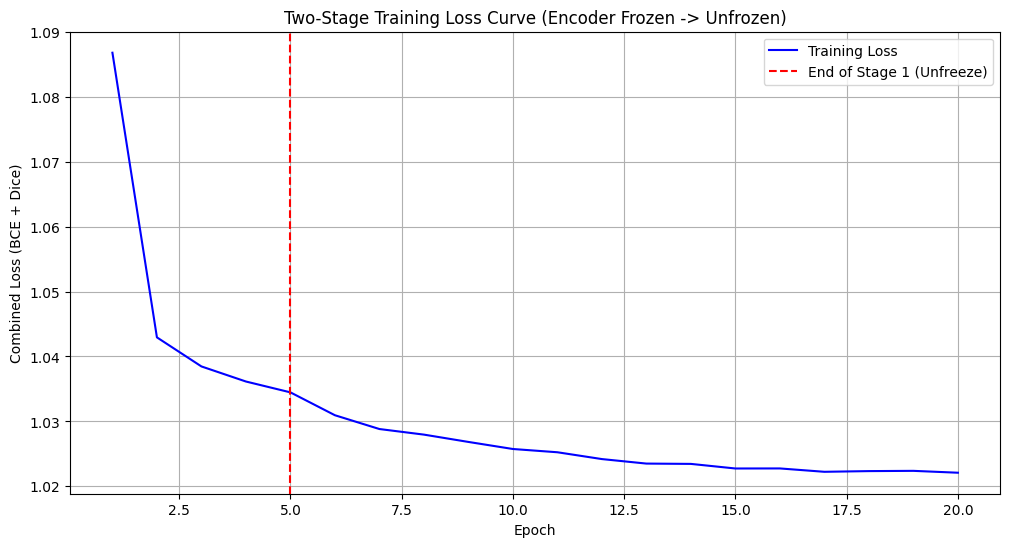

 U-Net Model created with: efficientnet-b3 encoder.
 Encoder weights: imagenet (Transfer Learning)
 Decoder weights: Randomly Initialized (By default)

Final Model Loaded and Ready for Testing.


In [ ]:



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
history = {'train_loss': []} # Initialize history to track both stages


freeze_encoder(model)
# Use the initial OPTIMIZER (lr=0.0001) without a scheduler for stable start
scheduler_stage_1 = None

print(f"Start LR for Stage 1: {OPTIMIZER.param_groups[0]['lr']}")

history = train_model(
    model=model,
    loss_fn=LOSS,
    optimizer=OPTIMIZER,
    scheduler=scheduler_stage_1, #  Passing the scheduler as none
    train_loader=train_loader,
    device=device,
    num_epochs=NUM_EPOCHS_STAGE_1,
    start_epoch=1,
    save_path=MODEL_SAVE_PATH,
    history=history
)



# 1. Load the best weights saved from Stage 1 to ensure continuity
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# 2. Unfreeze the entire network
unfreeze_encoder(model)

# 3. Define NEW OPTIMIZER with a smaller LR for fine-tuning
fine_tune_optimizer = torch.optim.Adam(model.parameters(), lr=FINE_TUNE_LR)

# 4. Define the COSINE ANNEALING SCHEDULER
scheduler_stage_2 = CosineAnnealingLR(
    optimizer=fine_tune_optimizer,
    T_max=NUM_EPOCHS_STAGE_2, # Decay over the 15 epochs of Stage 2
)

print(f"Start LR for Stage 2 (Fine-Tuning): {fine_tune_optimizer.param_groups[0]['lr']}")

history = train_model(
    model=model,
    loss_fn=LOSS,
    optimizer=fine_tune_optimizer,
    scheduler=scheduler_stage_2,
    train_loader=train_loader,
    device=device,
    num_epochs=NUM_EPOCHS_STAGE_2,
    start_epoch=NUM_EPOCHS_STAGE_1 + 1, # Start epoch count after Stage 1
    save_path=MODEL_SAVE_PATH,
    history=history
)


#Visualization and Checkpoint Loading (Remaining code)
import matplotlib.pyplot as plt

def plot_training_history(history, stage1_epochs):
    """Plots the reduction in training loss over epochs, showing the stage split."""
    plt.figure(figsize=(12, 6))
    epochs = range(1, len(history['train_loss']) + 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss', color='blue')

    # Highlight the transition between stages
    plt.axvline(x=stage1_epochs, color='red', linestyle='--', label='End of Stage 1 (Unfreeze)')

    plt.title('Two-Stage Training Loss Curve (Encoder Frozen -> Unfrozen)')
    plt.xlabel('Epoch')
    plt.ylabel('Combined Loss (BCE + Dice)')
    plt.legend()
    plt.grid(True)
    plt.show()

# 1. Plot the loss history
plot_training_history(history, NUM_EPOCHS_STAGE_1)

# 2. Load the best saved weights (for testing/future use)
# Re-initialize the model structure (Assuming create_unet_model is in the global scope)
final_model = create_unet_model(ENCODER, ENCODER_WEIGHTS, NUM_CLASSES, ACTIVATION)
final_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
final_model.to(device)
final_model.eval()

print("\nFinal Model Loaded and Ready for Testing.")

#Model Evaluation and Visualization

This section performs testing, evaluation, and visualization of the trained segmentation model.

Model Used:
U-Net with EfficientNet-B3 encoder (pretrained on ImageNet).
The decoder was randomly initialized and trained in two stages (frozen encoder → unfrozen encoder).
Final weights are loaded from:
/content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth.

Testing Paths:

Test images: /content/drive/MyDrive/Car/cars/cars_test/cars_test

Test masks: /content/drive/MyDrive/Car/cars/cars_test/cars_test_mask_yolov8x

Visualization output: /content/drive/MyDrive/decoder_only_result/2stages_visualizations

Loss Functions (Used for metric computation):

DiceLoss → returns (1 − Dice Coefficient), measures region overlap.

JaccardLoss → returns (1 − IoU), measures intersection over union.

--------------------------------

Metrics Computed:

- Mean IoU

- Mean Dice Coefficient

- Pixel Accuracy

- Precision

- Recall
---------------------------------------------------------------
Evaluation Flow:

Load trained model weights and move to GPU.

Run inference on test dataset using DataLoader.

Compute loss-based and pixel-level metrics (IoU, Dice, Accuracy, Precision, Recall).

Save visualizations (original image, ground truth mask, predicted mask) for first 40 batches to visualize qualitative performance.

Purpose:
To assess segmentation accuracy of the trained model and generate visual samples showing prediction quality for car vs background segmentation.

In [ ]:
import os
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import cv2 # Ensure cv2 is imported for visualization functions

# ASSUMED EXTERNAL DEFINITIONS
# NOTE: The following functions must be defined in your notebook prior to this cell:
# def calculate_pixel_accuracy(output, mask, threshold=0.5): ...
# def get_base_metrics(output, mask, threshold=0.5): ...
# CarSegmentationDataset, data_transforms, final_model, device, DRIVE_PATH
DRIVE_PATH = '/content/drive/MyDrive/Car/cars/cars_train'
# TESTING PATHS
TEST_BASE_PATH = DRIVE_PATH.replace('cars_train', 'cars_test')
TEST_IMAGE_DIR = os.path.join(TEST_BASE_PATH, 'cars_test')
TEST_MASK_DIR = os.path.join(TEST_BASE_PATH, 'cars_test_mask_yolov8x')
SAVE_ROOT_FOLDER = '/content/drive/MyDrive/decoder_only_result'

# 1. New Model Save Path (Weights)


MODEL_SAVE_PATH = os.path.join(DRIVE_PATH, 'efficientnet_b3.pth')

# 2. New Visualization Path (Results)
VISUALIZATION_DIR = os.path.join(SAVE_ROOT_FOLDER, '2stages_visualizations')
os.makedirs(VISUALIZATION_DIR, exist_ok=True)


#These are defined again because of runtime error issue
# Model Configuration
ENCODER = 'efficientnet-b3'
# Use 'imagenet' for the ENCODER weights, and the DECODER weights remain random.
ENCODER_WEIGHTS = 'imagenet'
# Since this is binary segmentation (Car vs. Background), we use 1 class.
NUM_CLASSES = 1
# Sigmoid is used for binary segmentation tasks
ACTIVATION = 'sigmoid'

final_model = create_unet_model(ENCODER, ENCODER_WEIGHTS, NUM_CLASSES, ACTIVATION)
# Use map_location to ensure compatibility if weights were saved on CPU
final_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
print(f"Loaded final weights from: {MODEL_SAVE_PATH}")


# CRITICAL STEP: Move the model (including the newly loaded weights) to the GPU
final_model.to(device)
final_model.eval()
# Print all the statements
print(f'TEST_BASE_PATH: {TEST_BASE_PATH}')
print(f'TEST_IMAGE_DIR: {TEST_IMAGE_DIR}')
print(f'TEST_MASK_DIR: {TEST_MASK_DIR}')
print(f'VISUALIZATION_DIR: {VISUALIZATION_DIR}')

# Create the test dataset and DataLoader
TEST_BATCH_SIZE = 4
test_dataset = CarSegmentationDataset(
    image_dir=TEST_IMAGE_DIR,
    mask_dir=TEST_MASK_DIR,
    transform=data_transforms
)
test_loader = DataLoader(
    test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

# METRIC SETUP
metrics_calculators = {
    # DiceLoss returns (1 - Dice_Coefficient).
    'dice_loss': smp.losses.DiceLoss(mode='binary', smooth=1e-6),
    # JaccardLoss returns (1 - IoU).
    'iou_loss': smp.losses.JaccardLoss(mode='binary', smooth=1e-6)
}


# MISSING HELPER FUNCTIONS (You must define these earlier)
def get_base_metrics(output, mask, threshold=0.5):
    """Calculates True Positives, False Positives, False Negatives, and True Negatives."""
    pred_mask = (output > threshold).float()
    mask = mask.float()

    tp = (pred_mask * mask).sum().item()
    fp = (pred_mask * (1 - mask)).sum().item()
    fn = ((1 - pred_mask) * mask).sum().item()
    tn = ((1 - pred_mask) * (1 - mask)).sum().item()

    return tp, fp, fn, tn

def calculate_pixel_accuracy(output, mask, threshold=0.5):
    """Calculates pixel-wise accuracy."""
    pred_mask = (output > threshold).float()
    correct_pixels = (pred_mask == mask).sum().item()
    total_pixels = mask.numel()
    return correct_pixels / total_pixels


def visualize_predictions(images, true_masks, pred_probs, vis_dir, start_index): # <--- NEW ARGUMENT ADDED
    """Saves the original image, true mask, and predicted mask for a batch, using a unique start_index."""

    for i in range(images.size(0)):
        unique_index = start_index + i # Calculate the unique index across the entire dataset

        # Convert tensors to NumPy arrays
        img = images[i].permute(1, 2, 0).numpy() * 255.0
        true_mask = true_masks[i].squeeze().numpy()
        pred_mask_prob = pred_probs[i].squeeze().numpy()

        # Convert probability mask to binary mask (0 or 255)
        pred_binary_mask = (pred_mask_prob > 0.5).astype(np.uint8) * 255

        # Save Images using the unique index
        img_name = f"test_sample_{unique_index:04d}" # Ensure unique naming (e.g., 0000, 0001, ...)

        # Original Image
        cv2.imwrite(os.path.join(vis_dir, f"{img_name}_original.png"), cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2BGR))

        # Ground Truth Mask
        cv2.imwrite(os.path.join(vis_dir, f"{img_name}_truth.png"), true_mask * 255)

        # Predicted Mask (Binary)
        cv2.imwrite(os.path.join(vis_dir, f"{img_name}_predicted.png"), pred_binary_mask)

    print(f"\n🖼️ Saved {images.size(0)} visualization samples (Indices {start_index} to {start_index + images.size(0) - 1}) to {vis_dir}")




def evaluate_and_visualize_model(model, test_loader, device, metrics_calculators, vis_dir):
    """Runs inference and calculates IoU, Dice, Accuracy, Precision, and Recall."""
    model.eval()
    total_dice_loss = 0.0
    total_iou_loss = 0.0

    # NEW TRACKERS FOR BASE PIXEL COUNTS
    total_tp, total_fp, total_fn, total_tn = 0, 0, 0, 0
    total_samples = 0

    print("\n" + "="*50)
    print(" Starting Testing and Evaluation...")


    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(tqdm(test_loader, desc="Evaluating")):
            images = images.to(device)
            masks = masks.to(device)

            # 1. Forward Pass
            outputs = model(images)

            # 2. Calculate Loss-based Metrics (IoU and Dice)
            total_dice_loss += metrics_calculators['dice_loss'](outputs, masks).item() * images.size(0)
            total_iou_loss += metrics_calculators['iou_loss'](outputs, masks).item() * images.size(0)

            # 3. Calculate Base Metrics (TP, FP, FN, TN)
            batch_tp, batch_fp, batch_fn, batch_tn = get_base_metrics(outputs, masks)
            total_tp += batch_tp
            total_fp += batch_fp
            total_fn += batch_fn
            total_tn += batch_tn

            # 4. Visualize and Save Masks (FIXED: Uses current sample count for unique naming)
            if batch_idx <= 40: # Saves the first 41 batches (41 * 4 = 164 images)
                visualize_predictions(images.cpu(), masks.cpu(), outputs.cpu(), vis_dir, total_samples) # <--- PASSING THE START INDEX

            # CRITICAL: Update total_samples *after* visualization uses the current count
            total_samples += images.size(0)


    # 5. Final Results Calculation
    total_pixels = total_tp + total_fp + total_fn + total_tn

    # Loss-based Overlap Metrics
    mean_dice_coefficient = 1.0 - (total_dice_loss / total_samples)
    mean_iou = 1.0 - (total_iou_loss / total_samples)

    # Derived Classification Metrics
    pixel_accuracy = (total_tp + total_tn) / total_pixels
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0


    # 6. Printing the Results
    print("\n" + "="*50)
    print("Evaluation Complete.")
    print("--- OVERLAP METRICS (Primary Segmentation Focus) ---")
    print(f"Mean IoU (Intersection over Union): {mean_iou:.4f}")
    print(f"Mean Dice Coefficient (F1-Score): {mean_dice_coefficient:.4f}")
    print("\n--- CLASSIFICATION METRICS (Pixel Quality) ---")
    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("="*50)

    return {'iou': mean_iou, 'dice': mean_dice_coefficient, 'accuracy': pixel_accuracy, 'precision': precision, 'recall': recall}

# --- RUN EVALUATION ---
test_results = evaluate_and_visualize_model(final_model, test_loader, device, metrics_calculators, VISUALIZATION_DIR)

 U-Net Model created with: efficientnet-b3 encoder.
 Encoder weights: imagenet (Transfer Learning)
 Decoder weights: Randomly Initialized (By default)
Loaded final weights from: /content/drive/MyDrive/Car/cars/cars_train/efficientnet_b3.pth
TEST_BASE_PATH: /content/drive/MyDrive/Car/cars/cars_test
TEST_IMAGE_DIR: /content/drive/MyDrive/Car/cars/cars_test/cars_test
TEST_MASK_DIR: /content/drive/MyDrive/Car/cars/cars_test/cars_test_mask_yolov8x
VISUALIZATION_DIR: /content/drive/MyDrive/decoder_only_result/2stages_visualizations
Checking dataset integrity...
  --> Mask missing for: 00003.jpg. Excluding from dataset.
  --> Mask missing for: 00013.jpg. Excluding from dataset.
  --> Mask missing for: 00017.jpg. Excluding from dataset.
  --> Mask missing for: 00029.jpg. Excluding from dataset.
  --> Mask missing for: 00038.jpg. Excluding from dataset.
  --> Mask missing for: 00045.jpg. Excluding from dataset.
  --> Mask missing for: 00047.jpg. Excluding from dataset.
  --> Mask missing for: 0

Evaluating:   0%|          | 0/1831 [00:00<?, ?it/s]


🖼️ Saved 4 visualization samples (Indices 0 to 3) to /content/drive/MyDrive/decoder_only_result/2stages_visualizations

🖼️ Saved 4 visualization samples (Indices 4 to 7) to /content/drive/MyDrive/decoder_only_result/2stages_visualizations

🖼️ Saved 4 visualization samples (Indices 8 to 11) to /content/drive/MyDrive/decoder_only_result/2stages_visualizations

🖼️ Saved 4 visualization samples (Indices 12 to 15) to /content/drive/MyDrive/decoder_only_result/2stages_visualizations

🖼️ Saved 4 visualization samples (Indices 16 to 19) to /content/drive/MyDrive/decoder_only_result/2stages_visualizations

🖼️ Saved 4 visualization samples (Indices 20 to 23) to /content/drive/MyDrive/decoder_only_result/2stages_visualizations

🖼️ Saved 4 visualization samples (Indices 24 to 27) to /content/drive/MyDrive/decoder_only_result/2stages_visualizations

🖼️ Saved 4 visualization samples (Indices 28 to 31) to /content/drive/MyDrive/decoder_only_result/2stages_visualizations

🖼️ Saved 4 visualization sam

-------------------------------------------------------------------------------
----------------------------------
---------------
----------------------------------



DECODER ONLY








--------------------------
--------------------------------------
------------------------------------------------
----------------------------------------------------------


#Decoder-Only Training (Single-Stage Fine-Tuning)

In this phase, we train the decoder only using the YOLOv8x-generated car masks, replicating the earlier training process but simplifying it to a single-stage approach.

Unlike the previous two-stage training (where the encoder was later unfrozen for fine-tuning), here we:

Freeze the entire encoder (EfficientNet-B3) to retain its pre-trained ImageNet feature extraction ability.

Train only the decoder for 25 epochs, allowing it to adapt specifically to the car segmentation task.

Keep the encoder weights fixed to prevent overfitting and reduce computation time.

This setup focuses on optimizing the upsampling path (decoder) for better mask reconstruction while leveraging the strong pre-learned representations of the encoder.

Key details:

Training epochs: 25 (single stage)

Encoder: EfficientNet-B3 (frozen, pre-trained on ImageNet)

Decoder: Trainable, randomly initialized

Loss Function: 0.5 * Combined BCE +  Dice loss
NOT(1:1 ratio)

BCE (Binary Cross-Entropy): Ensures per-pixel classification accuracy.

Dice Loss: Improves overlap quality between prediction and ground truth.

Optimizer: Adam (LR = 0.000065)

This approach is computationally efficient and ideal when the encoder already possesses strong general visual features, focusing training solely on refining the segmentation-specific decoding layers.

In [ ]:
from google.colab import drive
# This command mounts your Google Drive to the path /content/drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#iNSTALLING THE smp LIBRARY AS IT makes it easy
!pip install -qq segmentation-models-pytorch albumentations torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.7 MB/s eta 0:00:00


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import segmentation_models_pytorch as smp
import cv2
import numpy as np



# --- Define your provided paths ---
DRIVE_PATH = '/content/drive/MyDrive/Car/cars/cars_train'
print(f'{DRIVE_PATH}')
INPUT_IMAGE_DIR = os.path.join(DRIVE_PATH, 'cars_train')
OUTPUT_MASK_DIR = os.path.join(DRIVE_PATH, 'cars_train_mask_yolov8x')

# --- Model Configuration ---
ENCODER = 'efficientnet-b3'
# Use 'imagenet' for the ENCODER weights, and the DECODER weights remain random.
ENCODER_WEIGHTS = 'imagenet'
# Since this is binary segmentation (Car vs. Background), we use 1 class.
NUM_CLASSES = 1
# Sigmoid is used for binary segmentation tasks
ACTIVATION = 'sigmoid'

/content/drive/MyDrive/Car/cars/cars_train


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 61.1 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

from segmentation_models_pytorch import utils



# ------------------

# Define device (Crucial for .to(device) calls)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Define your provided paths ---
# Assuming DRIVE_PATH has been defined in a previous cell or globally
DRIVE_PATH = '/content/drive/MyDrive/Car/cars/cars_train'
INPUT_IMAGE_DIR = os.path.join(DRIVE_PATH, 'cars_train')
OUTPUT_MASK_DIR = os.path.join(DRIVE_PATH, 'cars_train_mask_yolov8x')

# --- Configuration for Data ---
U_NET_TARGET_SIZE = (320, 320) # Optimal size for EfficientNet-B3 U-Net
BATCH_SIZE = 8


# --- Define the function to check for the corresponding mask path ---
def get_mask_path(image_name, mask_dir):
    """
    Tries to find the mask file, checking for common extensions.
    """
    base_name, ext = os.path.splitext(image_name)

    # 1. Check for common mask extensions (PNG is common for YOLO/segmentation masks)
    mask_path_png = os.path.join(mask_dir, base_name + '.png')
    if os.path.exists(mask_path_png):
        return mask_path_png

    # 2. Check for the original image extension (in case masks kept the original extension)
    mask_path_original_ext = os.path.join(mask_dir, image_name)
    if os.path.exists(mask_path_original_ext):
        return mask_path_original_ext

    return None # Return None if no mask is found


class CarSegmentationDataset(Dataset):
    """Custom Dataset for loading images and masks with robust filtering."""
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        all_images = sorted(os.listdir(image_dir))
        self.images = []
        excluded_count = 0

        # --- PROACTIVE FILTERING IN __INIT__ ---
        print("Checking dataset integrity...")
        for img_name in all_images:
            mask_path = get_mask_path(img_name, mask_dir)

            # Only keep the image name if a corresponding mask file is found
            if mask_path is not None:
                self.images.append(img_name)
            else:
                # Print which files are excluded
                print(f"  --> Mask missing for: {img_name}. Excluding from dataset.")
                excluded_count += 1

        print("="*50)
        print(f"Dataset ready. Loaded {len(self.images)} image-mask pairs.")
        print(f"Total excluded masks: {excluded_count}")
        print("="*50)


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Get the mask path, guaranteed to exist due to __init__ filtering
        mask_path = get_mask_path(img_name, self.mask_dir)

        # Read Image and Mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # --- CRITICAL VALIDATION CHECK for CORRUPTED FILES ---
        # This handles files that are present but unreadable or empty (size 0).
        if image is None or image.size == 0 or mask is None or mask.size == 0:
             # This error will break the worker process, but it correctly flags
             # the issue with the specific file, preventing the silent crash.
             raise RuntimeError(f"Corrupted or empty file detected for {img_name}. File is present but invalid.")


        # Normalize mask to 0/1 range. The mask read from cv2.imread is 2D (H, W).
        mask = (mask > 0).astype(np.float32)

        # Apply transformations (Resize) on 2D mask and 3D image
        if self.transform is not None:
            image, mask = self.transform(image, mask)

        # Now, add the channel dimension to the mask (C, H, W)
        mask = np.expand_dims(mask, axis=0) # [H, W] -> [1, H, W]

        # Convert HWC image to CHW and normalize
        image = image.transpose((2, 0, 1)).astype(np.float32) / 255.0

        return torch.from_numpy(image).float(), torch.from_numpy(mask).float()


# --- Define Transformations (Resizing function) ---
def data_transforms(image, mask, target_size=U_NET_TARGET_SIZE):
    """Resizes the image (HWC) and mask (2D) to the target size."""

    # We rely on the __getitem__ check to ensure image/mask are valid and non-empty NumPy arrays.

    # Ensure mask is 2D for cv2.resize if it somehow got an extra dimension
    if mask.ndim == 3 and mask.shape[2] == 1:
        mask = mask.squeeze(axis=2)

    # Resize the image and mask
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    return image, mask

# Create the dataset instance
train_dataset = CarSegmentationDataset(
    image_dir=INPUT_IMAGE_DIR,
    mask_dir=OUTPUT_MASK_DIR,
    transform=data_transforms
)

# Example DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

Checking dataset integrity...
  --> Mask missing for: 00003.jpg. Excluding from dataset.
  --> Mask missing for: 00005.jpg. Excluding from dataset.
  --> Mask missing for: 00023.jpg. Excluding from dataset.
  --> Mask missing for: 00025.jpg. Excluding from dataset.
  --> Mask missing for: 00028.jpg. Excluding from dataset.
  --> Mask missing for: 00030.jpg. Excluding from dataset.
  --> Mask missing for: 00035.jpg. Excluding from dataset.
  --> Mask missing for: 00040.jpg. Excluding from dataset.
  --> Mask missing for: 00047.jpg. Excluding from dataset.
  --> Mask missing for: 00056.jpg. Excluding from dataset.
  --> Mask missing for: 00060.jpg. Excluding from dataset.
  --> Mask missing for: 00068.jpg. Excluding from dataset.
  --> Mask missing for: 00086.jpg. Excluding from dataset.
  --> Mask missing for: 00095.jpg. Excluding from dataset.
  --> Mask missing for: 00097.jpg. Excluding from dataset.
  --> Mask missing for: 00104.jpg. Excluding from dataset.
  --> Mask missing for: 00

In [ ]:
def create_unet_model(encoder_name, encoder_weights, num_classes, activation):
    """
    Creates a U-Net model using segmentation_models_pytorch.

    The DECODER is automatically initialized randomly as no decoder_weights
    parameter is available or specified in the smp.Unet constructor.
    """

    #  Model Initialization
    # encoder_weights='imagenet' ensures the EfficientNet-B3 CONVOLUTIONAL
    # LAYERS are pre-trained.
    # The upsampling (DECODER) path is initialized randomly by default.
    model = smp.Unet(
        encoder_name=encoder_name,      # EfficientNet-B3
        encoder_weights=encoder_weights, # 'imagenet' (Pre-trained)
        in_channels=3,                  # RGB image
        classes=num_classes,            # 1 for binary segmentation (Car vs. Background)
        activation=activation           # 'sigmoid' for the final output layer
    )

    print(f" U-Net Model created with: {encoder_name} encoder.")
    print(f" Encoder weights: {encoder_weights} (Transfer Learning)")
    print(f" Decoder weights: Randomly Initialized (By default)")

    return model

# Create the final model
model = create_unet_model(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION
)

# Move model to GPU (essential for Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



# Using the built-in smp.losses.DiceLoss and smp.losses.SoftBCEWithLogitsLoss
# Note: SoftBCEWithLogitsLoss is the BCE loss that expects logits (raw model output)
# and is numerically stable.

import torch.nn as nn
import segmentation_models_pytorch as smp

# Define weights outside the class for easy configuration
ALPHA = 0.5
BETA = 1.0

class CombinedLoss(nn.Module):
    def __init__(self, alpha=ALPHA, beta=BETA):
        super(CombinedLoss, self).__init__()
        # Initialize the two components of the loss function
        self.dice_loss = smp.losses.DiceLoss(mode='binary', smooth=1.0, log_loss=False)
        self.bce_loss = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.0)
        self.alpha = alpha
        self.beta = beta
        print(f"Combined Loss Initialized: {alpha} * BCE + {beta} * Dice")

    def forward(self, y_pred, y_true):
        # Calculate individual losses
        loss_dice = self.dice_loss(y_pred, y_true)
        loss_bce = self.bce_loss(y_pred, y_true)

        # Calculate the weighted combined loss
        return self.alpha * loss_bce + self.beta * loss_dice
# LOSS = smp.losses.DiceLoss(mode='binary', smooth=1.0)
LOSS = CombinedLoss(alpha=ALPHA, beta=BETA)

OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.000065)

# The training function (train_model) can now correctly call loss_fn(outputs, masks)
# because LOSS is now a callable object that returns a single tensor (the loss value).

print(f"Loss Function: Combined Loss (ALPHA={ALPHA} * BCE + BETA={BETA} * Dice)")
print(f"Optimizer: Adam with LR=0.000065")

print(f"Model moved to: {device}")
print(f" Loss Function: Dice Loss (Good for segmentation)")
print(f" Optimizer: Adam with LR=0.000065")

 U-Net Model created with: efficientnet-b3 encoder.
 Encoder weights: imagenet (Transfer Learning)
 Decoder weights: Randomly Initialized (By default)
Combined Loss Initialized: 0.5 * BCE + 1.0 * Dice
Loss Function: Combined Loss (ALPHA=0.5 * BCE + BETA=1.0 * Dice)
Optimizer: Adam with LR=0.000065
Model moved to: cuda
 Loss Function: Dice Loss (Good for segmentation)
 Optimizer: Adam with LR=0.000065


In [ ]:
# --- ASSUMED VARIABLES ---
# The variables 'model', 'LOSS', 'OPTIMIZER', 'device', and configuration constants
# (ENCODER, ENCODER_WEIGHTS, NUM_CLASSES, ACTIVATION) are assumed defined from above.

# --- TRAINING CONFIGURATION ---
NUM_EPOCHS_DECODER_ONLY = 25 # Target: 25 epochs for decoder training
SAVE_FOLDER = '/content/drive/MyDrive/model_weights'

DECODER_ONLY_MODEL_PATH = os.path.join(SAVE_FOLDER, 'decoder_only_final_25e.pth')
# Since we are training the decoder only, we use the initial LR (0.0001) for this full 25 epochs.
SCHEDULER_EXTENDED = None

# --- HELPER FUNCTIONS (Required for Execution) ---

def freeze_encoder(model):
    """Sets requires_grad=False for all encoder parameters."""
    for param in model.encoder.parameters():
        param.requires_grad = False
    print("\nEncoder Frozen. Ready for Decoder-Only Calibration.")

def train_model(model, loss_fn, optimizer, scheduler, train_loader, device, num_epochs, start_epoch, save_path, history):
    """Performs the training loop (used for 25 epochs here)."""
    model.train()
    best_loss = float('inf') if not history['train_loss'] else min(history['train_loss'])

    print("\n" + "="*50)
    print(f"Resuming/Starting Training for {num_epochs} Epochs...")
    print("="*50)

    for epoch in range(start_epoch, start_epoch + num_epochs):
        epoch_loss = 0
        num_total_epochs = start_epoch + num_epochs - 1
        from tqdm.notebook import tqdm
        train_iter = tqdm(train_loader, desc=f"Epoch {epoch}/{num_total_epochs}")

        for images, masks in train_iter:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            train_iter.set_postfix({'Loss': loss.item(), 'LR': optimizer.param_groups[0]['lr']})

        if scheduler:
            scheduler.step()

        avg_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(avg_loss)

        print(f"\n--- Epoch {epoch} Complete | Average Loss: {avg_loss:.4f} ---")

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), save_path)
            print(f"   Model saved! New best loss: {best_loss:.4f} -> Saved to {save_path}")

    return history

import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plots the reduction in training loss over epochs, showing the stage split."""
    plt.figure(figsize=(12, 6))
    epochs = range(1, len(history['train_loss']) + 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss', color='blue')

    # Highlight the transition between stages
    plt.axvline(x=stage1_epochs, color='red', linestyle='--', label='End of Stage 1 (Unfreeze)')

    plt.title('Two-Stage Training Loss Curve (Encoder Frozen -> Unfrozen)')
    plt.xlabel('Epoch')
    plt.ylabel('Combined Loss (BCE + Dice)')
    plt.legend()
    plt.grid(True)
    plt.show()




history_decoder_only = {'train_loss': []}

# 1. Freeze the encoder
freeze_encoder(model)

# 2. Run extended training (using the existing OPTIMIZER with constant LR)
print(f"Start LR for Decoder-Only Training: {OPTIMIZER.param_groups[0]['lr']}")

history_decoder_only = train_model(
    model=model,
    loss_fn=LOSS,
    optimizer=OPTIMIZER,
    scheduler=SCHEDULER_EXTENDED, # None for constant LR
    train_loader=train_loader, # Assumed to be defined
    device=device,
    num_epochs=NUM_EPOCHS_DECODER_ONLY,
    start_epoch=1,
    save_path=DECODER_ONLY_MODEL_PATH, # Save to the new, specific path
    history=history_decoder_only
)

# --- POST-TRAINING VISUALIZATION AND FINAL LOAD ---
plot_training_history(history_decoder_only)


# Load the final best decoder-only model for evaluation
final_model_decoder_only = create_unet_model(ENCODER, ENCODER_WEIGHTS, NUM_CLASSES, ACTIVATION)
final_model_decoder_only.load_state_dict(torch.load(DECODER_ONLY_MODEL_PATH))
final_model_decoder_only.to(device)
final_model_decoder_only.eval()

print("\nFinal Decoder-Only Model Loaded and Ready for Testing.")






Encoder Frozen. Ready for Decoder-Only Calibration.
Start LR for Decoder-Only Training: 6.5e-05

Resuming/Starting Training for 25 Epochs...


Epoch 1/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 1 Complete | Average Loss: 0.7495 ---
   Model saved! New best loss: 0.7495 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 2/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 2 Complete | Average Loss: 0.7474 ---
   Model saved! New best loss: 0.7474 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 3/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 3 Complete | Average Loss: 0.7469 ---
   Model saved! New best loss: 0.7469 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 4/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 4 Complete | Average Loss: 0.7459 ---
   Model saved! New best loss: 0.7459 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 5/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 5 Complete | Average Loss: 0.7453 ---
   Model saved! New best loss: 0.7453 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 6/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 6 Complete | Average Loss: 0.7445 ---
   Model saved! New best loss: 0.7445 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 7/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 7 Complete | Average Loss: 0.7440 ---
   Model saved! New best loss: 0.7440 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 8/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 8 Complete | Average Loss: 0.7435 ---
   Model saved! New best loss: 0.7435 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 9/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 9 Complete | Average Loss: 0.7430 ---
   Model saved! New best loss: 0.7430 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 10/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 10 Complete | Average Loss: 0.7432 ---


Epoch 11/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 11 Complete | Average Loss: 0.7422 ---
   Model saved! New best loss: 0.7422 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 12/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 12 Complete | Average Loss: 0.7413 ---
   Model saved! New best loss: 0.7413 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 13/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 13 Complete | Average Loss: 0.7417 ---


Epoch 14/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 14 Complete | Average Loss: 0.7412 ---
   Model saved! New best loss: 0.7412 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 15/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 15 Complete | Average Loss: 0.7409 ---
   Model saved! New best loss: 0.7409 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 16/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 16 Complete | Average Loss: 0.7408 ---
   Model saved! New best loss: 0.7408 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 17/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 17 Complete | Average Loss: 0.7403 ---
   Model saved! New best loss: 0.7403 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 18/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 18 Complete | Average Loss: 0.7399 ---
   Model saved! New best loss: 0.7399 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 19/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 19 Complete | Average Loss: 0.7400 ---


Epoch 20/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 20 Complete | Average Loss: 0.7397 ---
   Model saved! New best loss: 0.7397 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 21/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 21 Complete | Average Loss: 0.7395 ---
   Model saved! New best loss: 0.7395 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 22/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 22 Complete | Average Loss: 0.7391 ---
   Model saved! New best loss: 0.7391 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 23/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 23 Complete | Average Loss: 0.7391 ---


Epoch 24/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 24 Complete | Average Loss: 0.7388 ---
   Model saved! New best loss: 0.7388 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


Epoch 25/25:   0%|          | 0/923 [00:00<?, ?it/s]


--- Epoch 25 Complete | Average Loss: 0.7388 ---
   Model saved! New best loss: 0.7388 -> Saved to /content/drive/MyDrive/model_weights/decoder_only_final_25e.pth


TypeError: plot_training_history() missing 1 required positional argument: 'stage1_epochs'

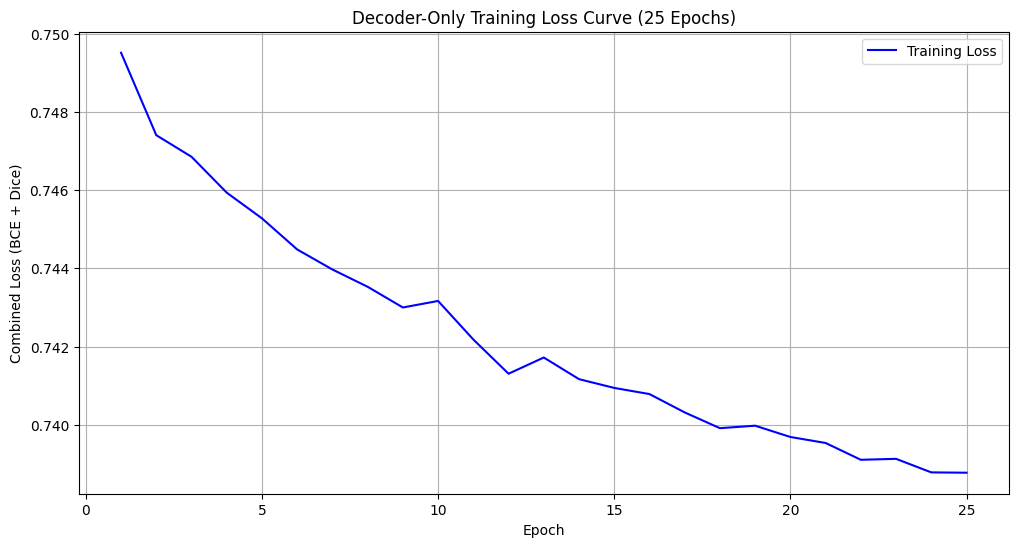

 U-Net Model created with: efficientnet-b3 encoder.
 Encoder weights: imagenet (Transfer Learning)
 Decoder weights: Randomly Initialized (By default)

Final Decoder-Only Model Loaded and Ready for Testing.


In [ ]:
def plot_training_history(history):
    """Plots the reduction in training loss over epochs."""
    plt.figure(figsize=(12, 6))
    epochs = range(1, len(history['train_loss']) + 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss', color='blue')
    plt.title('Decoder-Only Training Loss Curve (25 Epochs)')
    plt.xlabel('Epoch')
    plt.ylabel('Combined Loss (BCE + Dice)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history_decoder_only)
# Load the final best decoder-only model for evaluation
final_model_decoder_only = create_unet_model(ENCODER, ENCODER_WEIGHTS, NUM_CLASSES, ACTIVATION)
final_model_decoder_only.load_state_dict(torch.load(DECODER_ONLY_MODEL_PATH))
final_model_decoder_only.to(device)
final_model_decoder_only.eval()

print("\nFinal Decoder-Only Model Loaded and Ready for Testing.")

In [ ]:
import os
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import cv2 # Ensure cv2 is imported for visualization functions

# --- ASSUMED EXTERNAL DEFINITIONS ---
# NOTE: The following functions must be defined in your notebook prior to this cell:
# def calculate_pixel_accuracy(output, mask, threshold=0.5): ...
# def get_base_metrics(output, mask, threshold=0.5): ...
# CarSegmentationDataset, data_transforms, final_model, device, DRIVE_PATH

# --- TESTING PATHS ---
TEST_BASE_PATH = DRIVE_PATH.replace('cars_train', 'cars_test')
TEST_IMAGE_DIR = os.path.join(TEST_BASE_PATH, 'cars_test')
TEST_MASK_DIR = os.path.join(TEST_BASE_PATH, 'cars_test_mask_yolov8x')
SAVE_ROOT_FOLDER = '/content/drive/MyDrive/decoder_only_result'

# 1. New Model Save Path (Weights)
SAVE_FOLDER = '/content/drive/MyDrive/model_weights'

DECODER_ONLY_MODEL_PATH = os.path.join(SAVE_FOLDER, 'decoder_only_final_25e.pth')

# 2. New Visualization Path (Results)
VISUALIZATION_DIR = os.path.join(SAVE_ROOT_FOLDER, 'decoder_only_visualizations')
os.makedirs(VISUALIZATION_DIR, exist_ok=True)

# Print all the statements
print(f'TEST_BASE_PATH: {TEST_BASE_PATH}')
print(f'TEST_IMAGE_DIR: {TEST_IMAGE_DIR}')
print(f'TEST_MASK_DIR: {TEST_MASK_DIR}')
print(f'VISUALIZATION_DIR: {VISUALIZATION_DIR}')

# Create the test dataset and DataLoader
TEST_BATCH_SIZE = 4
test_dataset = CarSegmentationDataset(
    image_dir=TEST_IMAGE_DIR,
    mask_dir=TEST_MASK_DIR,
    transform=data_transforms
)
test_loader = DataLoader(
    test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

# --- METRIC SETUP ---
metrics_calculators = {
    # DiceLoss returns (1 - Dice_Coefficient).
    'dice_loss': smp.losses.DiceLoss(mode='binary', smooth=1e-6),
    # JaccardLoss returns (1 - IoU).
    'iou_loss': smp.losses.JaccardLoss(mode='binary', smooth=1e-6)
}

# -------------------------------------------------------------
# 2. EVALUATION FUNCTION (Includes All Requested Metrics)
# -------------------------------------------------------------
# --- MISSING HELPER FUNCTIONS (You must define these earlier) ---
def get_base_metrics(output, mask, threshold=0.5):
    """Calculates True Positives, False Positives, False Negatives, and True Negatives."""
    pred_mask = (output > threshold).float()
    mask = mask.float()

    tp = (pred_mask * mask).sum().item()
    fp = (pred_mask * (1 - mask)).sum().item()
    fn = ((1 - pred_mask) * mask).sum().item()
    tn = ((1 - pred_mask) * (1 - mask)).sum().item()

    return tp, fp, fn, tn

def calculate_pixel_accuracy(output, mask, threshold=0.5):
    """Calculates pixel-wise accuracy."""
    pred_mask = (output > threshold).float()
    correct_pixels = (pred_mask == mask).sum().item()
    total_pixels = mask.numel()
    return correct_pixels / total_pixels

# -------------------------------------------------------------
# 1. VISUALIZATION FUNCTION (FIXED for Unique Naming)
# -------------------------------------------------------------

def visualize_predictions(images, true_masks, pred_probs, vis_dir, start_index): # <--- NEW ARGUMENT ADDED
    """Saves the original image, true mask, and predicted mask for a batch, using a unique start_index."""

    for i in range(images.size(0)):
        unique_index = start_index + i # Calculate the unique index across the entire dataset

        # Convert tensors to NumPy arrays
        img = images[i].permute(1, 2, 0).numpy() * 255.0
        true_mask = true_masks[i].squeeze().numpy()
        pred_mask_prob = pred_probs[i].squeeze().numpy()

        # Convert probability mask to binary mask (0 or 255)
        pred_binary_mask = (pred_mask_prob > 0.5).astype(np.uint8) * 255

        # Save Images using the unique index
        img_name = f"test_sample_{unique_index:04d}" # Ensure unique naming (e.g., 0000, 0001, ...)

        # Original Image
        cv2.imwrite(os.path.join(vis_dir, f"{img_name}_original.png"), cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2BGR))

        # Ground Truth Mask
        cv2.imwrite(os.path.join(vis_dir, f"{img_name}_truth.png"), true_mask * 255)

        # Predicted Mask (Binary)
        cv2.imwrite(os.path.join(vis_dir, f"{img_name}_predicted.png"), pred_binary_mask)

    print(f"\n🖼️ Saved {images.size(0)} visualization samples (Indices {start_index} to {start_index + images.size(0) - 1}) to {vis_dir}")


# -------------------------------------------------------------
# 2. EVALUATION FUNCTION (Updated to Track Index and All Metrics)
# -------------------------------------------------------------

def evaluate_and_visualize_model(model, test_loader, device, metrics_calculators, vis_dir):
    """Runs inference and calculates IoU, Dice, Accuracy, Precision, and Recall."""
    model.eval()
    total_dice_loss = 0.0
    total_iou_loss = 0.0

    # NEW TRACKERS FOR BASE PIXEL COUNTS
    total_tp, total_fp, total_fn, total_tn = 0, 0, 0, 0
    total_samples = 0

    print("\n" + "="*50)
    print("🔬 Starting Testing and Evaluation...")
    print("="*50)

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(tqdm(test_loader, desc="Evaluating")):
            images = images.to(device)
            masks = masks.to(device)

            # 1. Forward Pass
            outputs = model(images)

            # 2. Calculate Loss-based Metrics (IoU and Dice)
            total_dice_loss += metrics_calculators['dice_loss'](outputs, masks).item() * images.size(0)
            total_iou_loss += metrics_calculators['iou_loss'](outputs, masks).item() * images.size(0)

            # 3. Calculate Base Metrics (TP, FP, FN, TN)
            batch_tp, batch_fp, batch_fn, batch_tn = get_base_metrics(outputs, masks)
            total_tp += batch_tp
            total_fp += batch_fp
            total_fn += batch_fn
            total_tn += batch_tn

            # 4. Visualize and Save Masks (FIXED: Uses current sample count for unique naming)
            if batch_idx <= 40: # Saves the first 41 batches (41 * 4 = 164 images)
                visualize_predictions(images.cpu(), masks.cpu(), outputs.cpu(), vis_dir, total_samples) # <--- PASSING THE START INDEX

            # CRITICAL: Update total_samples *after* visualization uses the current count
            total_samples += images.size(0)


    # 5. Final Results Calculation
    total_pixels = total_tp + total_fp + total_fn + total_tn

    # Loss-based Overlap Metrics
    mean_dice_coefficient = 1.0 - (total_dice_loss / total_samples)
    mean_iou = 1.0 - (total_iou_loss / total_samples)

    # Derived Classification Metrics
    pixel_accuracy = (total_tp + total_tn) / total_pixels
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0


    # 6. Printing the Results
    print("\n" + "="*50)
    print("✅ Evaluation Complete.")
    print("--- OVERLAP METRICS (Primary Segmentation Focus) ---")
    print(f"Mean IoU (Intersection over Union): {mean_iou:.4f}")
    print(f"Mean Dice Coefficient (F1-Score): {mean_dice_coefficient:.4f}")
    print("\n--- CLASSIFICATION METRICS (Pixel Quality) ---")
    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("="*50)

    return {'iou': mean_iou, 'dice': mean_dice_coefficient, 'accuracy': pixel_accuracy, 'precision': precision, 'recall': recall}

# --- RUN EVALUATION ---
test_results = evaluate_and_visualize_model(final_model_decoder_only, test_loader, device, metrics_calculators, VISUALIZATION_DIR)

TEST_BASE_PATH: /content/drive/MyDrive/Car/cars/cars_test
TEST_IMAGE_DIR: /content/drive/MyDrive/Car/cars/cars_test/cars_test
TEST_MASK_DIR: /content/drive/MyDrive/Car/cars/cars_test/cars_test_mask_yolov8x
VISUALIZATION_DIR: /content/drive/MyDrive/decoder_only_result/decoder_only_visualizations
Checking dataset integrity...
  --> Mask missing for: 00003.jpg. Excluding from dataset.
  --> Mask missing for: 00013.jpg. Excluding from dataset.
  --> Mask missing for: 00017.jpg. Excluding from dataset.
  --> Mask missing for: 00029.jpg. Excluding from dataset.
  --> Mask missing for: 00038.jpg. Excluding from dataset.
  --> Mask missing for: 00045.jpg. Excluding from dataset.
  --> Mask missing for: 00047.jpg. Excluding from dataset.
  --> Mask missing for: 00053.jpg. Excluding from dataset.
  --> Mask missing for: 00056.jpg. Excluding from dataset.
  --> Mask missing for: 00065.jpg. Excluding from dataset.
  --> Mask missing for: 00070.jpg. Excluding from dataset.
  --> Mask missing for: 0

Evaluating:   0%|          | 0/1831 [00:00<?, ?it/s]


🖼️ Saved 4 visualization samples (Indices 0 to 3) to /content/drive/MyDrive/decoder_only_result/decoder_only_visualizations

🖼️ Saved 4 visualization samples (Indices 4 to 7) to /content/drive/MyDrive/decoder_only_result/decoder_only_visualizations

🖼️ Saved 4 visualization samples (Indices 8 to 11) to /content/drive/MyDrive/decoder_only_result/decoder_only_visualizations

🖼️ Saved 4 visualization samples (Indices 12 to 15) to /content/drive/MyDrive/decoder_only_result/decoder_only_visualizations

🖼️ Saved 4 visualization samples (Indices 16 to 19) to /content/drive/MyDrive/decoder_only_result/decoder_only_visualizations

🖼️ Saved 4 visualization samples (Indices 20 to 23) to /content/drive/MyDrive/decoder_only_result/decoder_only_visualizations

🖼️ Saved 4 visualization samples (Indices 24 to 27) to /content/drive/MyDrive/decoder_only_result/decoder_only_visualizations

🖼️ Saved 4 visualization samples (Indices 28 to 31) to /content/drive/MyDrive/decoder_only_result/decoder_only_visu